# Assignment 3

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:

    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [2]:
pip install keras-tuner

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import keras_tuner as kt
from keras_tuner import HyperParameters

This lab continues our study of linear regression. You'll train your first models with Tensorflow, using a real dataset to predict car prices from their features. Note that Tensorflow is a rapidly changing library. This means you'll often see warnings about deprecations. You can ignore the warnings in our labs.

---
### Step 1: Data ingestion

You'll use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets).

In [4]:
# Provide the names for the feature columns since the CSV file with the data 
# does not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# Load the data from a CSV file into a pandas dataframe. Remember that each row
# is an example and each column in a feature.
car_data_init = pd.read_csv(
    'https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
    sep=',', names=cols, header=None, encoding='latin-1')

# Display top five rows
print('Shape of data:', car_data_init.shape)
car_data_init.head()

Shape of data: (205, 26)


,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


---
### Step 2: Data preprocessing

This step is essential for preparing the data in a format that is suitable for ML algorithms. It helps ensure data quality and improvements in model performance.

### <span style="color:chocolate">Exercise 1:</span> Column selection (5 points)

To keep things simple, you will:

1. Retain only the following columns: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']. Name the new dataframe *car_data*.
2. Display the data type of each column;
3. Convert the data type of each columns to numeric. Coerce missing values to NaN. Hint: use <span style="color:chocolate">pd.to_numeric()</span> method;
4. Display the data type of each column after the transformation performed at point 3.


In [5]:
# YOUR CODE HERE
# Step 1: Retain only the specified columns in the dataframe
car_data = car_data_init[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']]

# Step 2: Display the data type of each column
print(car_data.dtypes)
print(car_data)

# Step 3: Convert the data type of each column to numeric, coercing errors to NaN
car_data = car_data.apply(pd.to_numeric, errors='coerce')

# Step 4: Display the data type of each column after transformation
print(car_data.dtypes)

# Display the top rows of the transformed dataframe
car_data.head()


horsepower     object
peak-rpm       object
city-mpg        int64
highway-mpg     int64
price          object
dtype: object
    horsepower peak-rpm  city-mpg  highway-mpg  price
0          111     5000        21           27  13495
1          111     5000        21           27  16500
2          154     5000        19           26  16500
3          102     5500        24           30  13950
4          115     5500        18           22  17450
..         ...      ...       ...          ...    ...
200        114     5400        23           28  16845
201        160     5300        19           25  19045
202        134     5500        18           23  21485
203        106     4800        26           27  22470
204        114     5400        19           25  22625

[205 rows x 5 columns]
horsepower     float64
peak-rpm       float64
city-mpg         int64
highway-mpg      int64
price          float64
dtype: object


,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,111.0,5000.0,21,27,13495.0
1,111.0,5000.0,21,27,16500.0
2,154.0,5000.0,19,26,16500.0
3,102.0,5500.0,24,30,13950.0
4,115.0,5500.0,18,22,17450.0


### <span style="color:chocolate">Exercise 2:</span> Example (row) selection (5 points)

To keep things simple again, you will:

1. Print the shape of the car_data;

2. Remove examples (rows) that have missing value(s). Note that in doing so, you will overwrite the car_data dataset. You should end up with 199 examples after this cleaning.

3. Print the shape of the car_data again.

It's important to acknowledge that there are multiple approaches to handling missing features, and simply discarding examples with any missing feature, though straightforward, may not be the most optimal solution. However, for the sake of simplicity, you will implement this strategy in this assignment.

In [6]:
# YOUR CODE HERE
print("Shape of car_data before removing missing values:", car_data.shape)

# Step 2: Remove rows with missing values, overwriting the car_data dataset
car_data = car_data.dropna()

# Step 3: Print the shape of the car_data after removing missing values
print("Shape of car_data after removing missing values:", car_data.shape)

# Display the first few rows to verify
car_data.head()

Shape of car_data before removing missing values: (205, 5)
Shape of car_data after removing missing values: (199, 5)


,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,111.0,5000.0,21,27,13495.0
1,111.0,5000.0,21,27,16500.0
2,154.0,5000.0,19,26,16500.0
3,102.0,5500.0,24,30,13950.0
4,115.0,5500.0,18,22,17450.0


### <span style="color:chocolate">Exercise 3:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. Note that the original data (above) appears sorted by *make* in alphabetic order.

Using NumPy and Pandas methods:

1. Create a list of indices corresponding to the rows in the car_data dataset. Call this list *indices*. Print this list;

2. Shuffle *indices* using the <span style="color:chocolate">np.random.permutation()</span> method. Call the resulting array *shuffled_indices*. Print this array;
    
3. Use the method <span style="color:chocolate">dataframe.reindex()</span> to change the ordering of the car_data dataset based on the order in the *shuffled_indices* array. Note that in doing so, you will overwrite the original dataset. Print the top 5 rows.

In [14]:
np.random.seed(0)
# YOUR CODE 
# Step 1: Create a list of indices corresponding to the rows in the car_data dataset
indices = list(car_data.index)
print(indices)

# Step 2: Shuffle the indices using np.random.permutation
shuffled_indices = np.random.permutation(indices)
print("Shuffled indices:", shuffled_indices)

car_data = car_data.reindex(shuffled_indices)
print(car_data.head())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204]
Shuffled indices: [ 19 175 109  95 182 189   5 145  13 166  64 127 170 151  83   7  34 135
  38  77 165 150  4

### <span style="color:chocolate">Exercise 4:</span> Define outcome and features (5 points)

Create two dataframes as follows:

1. The first dataframe contains our outcome of interest: ['price']. Note, this is what we are aiming to predict. Name this dataframe Y. Print shape of Y.
2. The second dataframe contains our features of interest: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']. Name this dataframe X. Print shape of X.


In [15]:
# YOUR CODE HERE
# Step 1: Create the dataframe Y which contains only the 'price' column
Y = car_data[['price']]
print("Shape of Y (target variable):", Y.shape)

# Step 2: Create the dataframe X which contains the feature columns
X = car_data[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']]
print("Shape of X (features):", X.shape)

# Display the top rows of both dataframes to verify
print(Y.head())
print(X.head())


Shape of Y (target variable): (199, 1)
Shape of X (features): (199, 4)
       price
19    6295.0
175   9988.0
109  12440.0
95    7799.0
182   7775.0
     horsepower  peak-rpm  city-mpg  highway-mpg
19         70.0    5400.0        38           43
175        92.0    4200.0        27           32
109        97.0    5000.0        19           24
95         69.0    5200.0        31           37
182        52.0    4800.0        37           46


### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Partition the (X, Y) data into training, validation, and test sets using a splitting rule of [60%, 20%, 20%], with a random state set to 1234. Name the resulting dataframes as follows: X_train, X_val, X_test, Y_train, Y_val, Y_test. Hint: To create these three partitions you will utilize the train_test_split() method twice (all the other arguments of the method are set to default values.). You should obtain [119, 40, 40] examples for training, validation, and test, respectively.
2. Print the shape of each dataframe.

Note: The validation set is crucial for evaluating different hyperparameter configurations and selecting those that yield optimal model performance. This approach avoids utilizing the test dataset during model training, as it is assumed to be "unknown" at that stage.

In [22]:
# YOUR CODE HERE
# First split: Split X and Y into training (60%) and remaining (40%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=1234)

# Second split: Split the remaining 40% into validation (20%) and test (20%)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=1234)

# Print the shape of each dataframe
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

print("Y_train shape:", Y_train.shape)
print("Y_val shape:", Y_val.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (119, 4)
X_val shape: (40, 4)
X_test shape: (40, 4)
Y_train shape: (119, 1)
Y_val shape: (40, 1)
Y_test shape: (40, 1)


### <span style="color:chocolate">Exercise 6:</span> Data standardization (10 points)

With this concept in mind, complete the following tasks:

1. Output the quantile values (0.25, 0.5, 0.75, 0.95) for all features in the X_train dataset. Are these values uniformly scaled across features?

2. Standardize all features in X_train, X_val, and X_test. Label the resulting dataframes as X_train_std, X_val_std, and X_test_std, respectively. Hint: standardize the validation and test data using the mean and standard deviation computed from the training data. Why?

3. Similar to point 2. but now standardize the outcome variable. Label the resulting dataframes as Y_train_std, Y_val_std, and Y_test_std.

In [81]:
# YOUR CODE HERE
# Step 1: Output the quantile values for all features in the X_train dataset
quantiles = X_train.quantile([0.25, 0.5, 0.75, 0.95])
print(quantiles)

# Step 2: Standardize all features in X_train, X_val, and X_test using mean and std from X_train
mean_X_train = X_train.mean()
std_X_train = X_train.std()

# Standardize X datasets
X_train_std = (X_train - mean_X_train) / std_X_train
X_val_std = (X_val - mean_X_train) / std_X_train
X_test_std = (X_test - mean_X_train) / std_X_train

# Step 3: Standardize the outcome variable Y using the mean and std from Y_train
mean_Y_train = Y_train.mean()
std_Y_train = Y_train.std()

# Standardize Y datasets
Y_train_std = (Y_train - mean_Y_train) / std_Y_train
Y_val_std = (Y_val - mean_Y_train) / std_Y_train
Y_test_std = (Y_test - mean_Y_train) / std_Y_train

# Print the standardized dataframes
print(X_train_std.head())
print(X_val_std.head())
print(X_test_std.head())

print(Y_train_std.head())
print(Y_val_std.head())
print(Y_test_std.head())

      horsepower  peak-rpm  city-mpg  highway-mpg
0.25        69.0    4800.0      19.0         25.0
0.50        92.0    5000.0      25.0         31.0
0.75       116.0    5500.0      31.0         37.0
0.95       182.2    5900.0      37.0         42.1
     horsepower  peak-rpm  city-mpg  highway-mpg
8      0.992920  0.904123 -1.310752    -1.569388
168    0.385427 -0.648732 -0.248635    -0.167307
104    1.499165  0.238614 -1.007290    -0.868347
140   -0.703000 -1.536077  0.054827    -0.027099
108   -0.146130 -2.090668  0.358289     0.253317
     horsepower  peak-rpm  city-mpg  highway-mpg
146   -0.475189 -0.648732  0.358289     0.113109
145    0.258865 -0.648732 -0.248635    -0.307515
171    0.385427 -0.648732 -0.248635    -0.167307
47     1.904161 -0.759650 -1.614214    -1.709596
35    -0.627063  2.013305  0.661751     0.393525
     city-mpg  highway-mpg  horsepower make  peak-rpm
125 -1.007290    -0.587931    1.068857  NaN  0.904123
53   0.813482     0.954357   -0.829561  NaN -0.205059


Answer 1 Explaination: These values show the distribution of each feature in the dataset but indicate that the features are not uniformly scaled across the board, as the ranges vary significantly between features (e.g., horsepower and peak-rpm).

Answer 2 Explaination: This ensures that the validation and test sets are scaled consistently with the training data, which is important for model evaluation to avoid data leakage.

Note 1: Centering and Scaling the Data:
We standardize using the formula 
X_train_std = (X_train - mean_X_train) / std_X_train 
to center the data, ensure features are on the same scale, and improve the efficiency and performance of machine learning models, particularly those sensitive to feature scaling.
- Centering: Subtracting the mean from each feature shifts the distribution so that the mean of the standardized data becomes 0.
- Scaling: Dividing by the standard deviation scales the data so that the variance of each feature is 1. This standardization gives all features equal importance, preventing features with larger numeric ranges from dominating the learning process.

Note 2: We compute the mean and standard deviation only on X_train (the training set) and use these values to standardize X_val (validation set) and X_test (test set) for a few key reasons related to machine learning best practices:

1. Avoiding Data Leakage:
In machine learning, it's important to avoid using any information from the validation or test sets during model training. If we were to calculate the mean and standard deviation from the entire dataset (including the validation and test sets), we would be introducing information from those sets into the training process.
This is called data leakage, which can lead to overly optimistic model performance and poor generalization to new, unseen data.
2. Simulating Real-World Conditions:
In a real-world scenario, when deploying a model to predict new data, we will not know the future data in advance. The model will be trained on a dataset (training data), and when applied to new data (test or unseen data), we should apply the same transformations based solely on what was learned from the training data.
By using only the mean and standard deviation from X_train, we simulate this scenario, ensuring that the model is evaluated as it would be in production.
3. Ensuring Consistent Scaling:
Standardizing the training data (X_train) and then applying the same scaling to validation (X_val) and test data (X_test) ensures consistency across all sets.
If each dataset (train, validation, test) were scaled using its own mean and standard deviation, the model might be biased or inconsistent in handling features, as the scaling would differ across sets.

---
### Step 3: Exploratory data analysis (EDA)

EDA plays a very important role in ML. The goal here is to develop a good understanding of our training dataset, identify any data quality issues, understand patterns and relationships, which in turn, aids in subsequent modeling and interpretations.

### <span style="color:chocolate">Exercise 7:</span> Scatterplot matrix (10 points)

In this exercise you will use some simple yet useful techniques to visualize the distribution of the data. 

Let's start with:

1. A scatterplot matrix to visualize the pair-wise correlations between different features and outcome in the (X_train_std, Y_train_std) data. You will use the <span style="color:chocolate">sns.pairplot()</span> method from the seaborn library imported at the top of the notebook;
2. Is any of the variables in the data normally distributed? Is it necessary for the explanatory or target variable to be normally distributed in order to train a ML model?

     horsepower  peak-rpm  city-mpg  highway-mpg     price
8      0.992920  0.904123 -1.310752    -1.569388  1.270464
168    0.385427 -0.648732 -0.248635    -0.167307 -0.414324
104    1.499165  0.238614 -1.007290    -0.868347  0.480379
140   -0.703000 -1.536077  0.054827    -0.027099 -0.655278
108   -0.146130 -2.090668  0.358289     0.253317  0.007110
..          ...       ...       ...          ...       ...
39    -0.373940  1.569632  0.206558     0.253317 -0.508291
191    0.233553  0.904123 -1.007290    -1.008555  0.018353
99    -0.095506  0.238614  0.206558     0.393525 -0.495983
143   -0.171443  0.238614  0.054827     0.113109 -0.376334
78    -0.829561  0.904123  0.813482     0.954357 -0.765814

[119 rows x 5 columns]


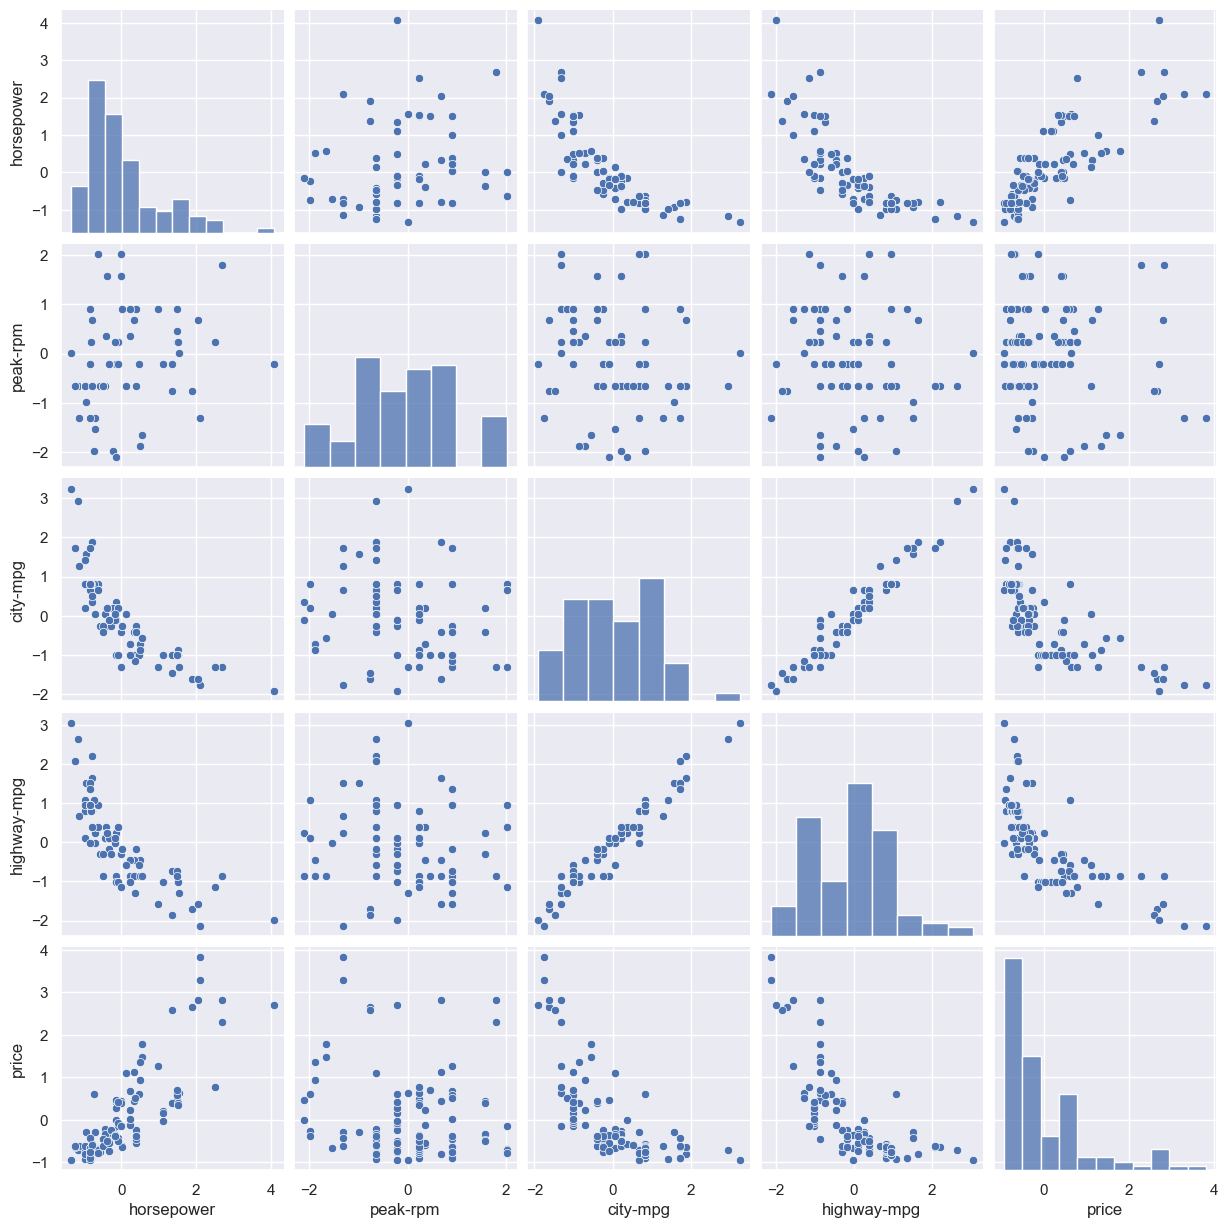

In [31]:
# YOUR CODE HERE
#print(X_train_std)
#print(Y_train_std)
#print(X_train_std.shape)
#print(Y_train_std.shape)

train_data_std = pd.concat([X_train_std, Y_train_std], axis=1)
print(train_data_std)

sns.pairplot(train_data_std)
plt.show()


Based on the scatterplot, we can visually inspect whether any feature or the target variable exhibits a normal distribution. And no, it is not strictly necessary for explanatory or target variables to be normally distributed in order to train a machine learning model. Standardization or normalization is primarily used to help models converge faster or to improve performance by ensuring all features are on the same scale.

### <span style="color:chocolate">Exercise 8:</span> Correlation matrix (10 points)

In this exercise you will:

1. Plot a correlation matrix in the form of a heatmap to visualize the linear relationships between different features and outcome in the (X_train_std, Y_train_std) data. Hint: this example here is very useful: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
2. Answer the following questions: 
 - Which two features are likely to be most redundant?
 - Which feature is likely to be least useful for predicting price?

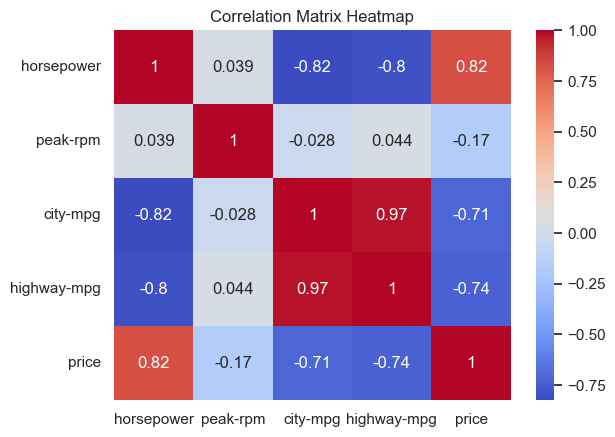

In [37]:
# YOUR CODE HERE
# Step 1: Calculate the correlation matrix
corr_matrix = train_data_std.corr()

# Step 2: Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

Answer:
1. Two features that have a very high positive or negative correlation (close to +1 or -1) are likely to be redundant because they carry similar information. Based on the heatmap, you can analyze the pairs of features that have strong correlations.
2. The feature with the lowest correlation (close to 0) with the target variable (price) is likely to be least useful for predicting price. This feature would have the weakest linear relationship with the target.


---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 9:</span> Baseline model (5 points)

Let's start by evaluating a baseline model. Precisely, you'll use the average price of cars in the training set as our baseline model -- that is, the baseline always predicts the average price regardless of the input.

1. Implement this baseline using the Y_train_std data and print the average price. Note: You can revert the price variable to the original scale for interpretation purposes.

In [45]:
# YOUR CODE HERE
# Calculate the average price in the standardized training set (Y_train_std)
average_price_std = Y_train_std.mean()

# Revert the average price to the original scale
average_price_original = average_price_std * std_Y_train + mean_Y_train

# Print the average price in the standardized and original scale
print(f"Average price (standardized): {average_price_std}")
print(f"Average price (original scale): {average_price_original}")


Average price (standardized): price   -6.903908e-17
dtype: float64
Average price (original scale): price    13139.92437
dtype: float64


### <span style="color:chocolate">Exercise 10:</span> Improvement over Baseline with TensorFlow (10 points)

Let's train a linear regression model much like we did in the previous assignment, but this time using TensorFlow. 

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: refer to Demo 3 in [bCourses/Modules/Live Session Demos](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) for an example.
2. Build and compile a model using the build_model() function and the (X_train_std, Y_train_std) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_std, Y_train_std) data. Set num_epochs = 5. Pass the (X_val_std, Y_val_std) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method.
3. Generate a plot with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method returns.

More notes on point 1: the idea is to build a *computational graph* for linear regression, and then send data through it. There are many ways to build graphs, but [TenforFlow Keras API](https://www.tensorflow.org/api_docs/python/tf/keras) is recommended. 

In [47]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim is 1 (because it's linear regression)
      input_shape=(num_features,),  # input dim is the number of features
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.keras.initializers.Ones(),  # initialize params to 1
      bias_initializer=tf.keras.initializers.Ones(),    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use GD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. This finalizes the graph for training.
  # We specify the MSE loss and the optimizer above
  model.compile(optimizer=optimizer, loss='mean_squared_error')
    
  return model

In [91]:
tf.random.set_seed(0)
# 2. Build and compile model
# YOUR CODE HERE
num_features = X_train_std.shape[1]  # The number of input features
learning_rate = 0.0001
model_tf = build_model(num_features, learning_rate)

# 3. Fit the model
# YOUR CODE HERE
num_epochs = 5
history = model_tf.fit(
    X_train_std, Y_train_std,       # training data
    epochs=num_epochs,              # number of epochs
    validation_data=(X_val_std, Y_val_std)  # validation data
)

Epoch 1/5


c:\Users\myk53\hello\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6.6394 - val_loss: 5.2507
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6195 - val_loss: 5.2371
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5997 - val_loss: 5.2236
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5800 - val_loss: 5.2101
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5604 - val_loss: 5.1967


---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as learning rate, number of epochs, and optimizer to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 11:</span> Hyperparameter tuning (10 points)

1. Fine-tune the **learning rate** and **number of epochs** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). If you decide to work with the Keras Tuner, define a new model building function named <span style="color:chocolate">build_model_tuner()</span>.

After identifying your preferred model configuration, print the following information:

2. The learned parameters of the tuned model (this should include the bias term). Hint: use  <span style="color:chocolate">[model_name].layers[0].get_weights()</span>.
3. The loss at the final epoch on both the training and validation datasets;
4. The difference between the last-epoch loss observed on the training and validation datasets.


Please note that we will consider 'optimal model configuration' any last-epoch training loss that is below 0.31 and any last epoch validation loss that is below 0.48.

Epoch 1/100


c:\Users\myk53\hello\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.6281 - val_loss: 0.8045
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6810 - val_loss: 0.4005
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3952 - val_loss: 0.3380
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3265 - val_loss: 0.3220
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2980 - val_loss: 0.3129
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2810 - val_loss: 0.3065
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2697 - val_loss: 0.3020
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2618 - val_loss: 0.2990
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2563 - val_loss: 0.2971
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2524 - val_loss: 0.2959
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2496 - val_loss: 0.2952
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2476 - val_loss: 0.2948
E

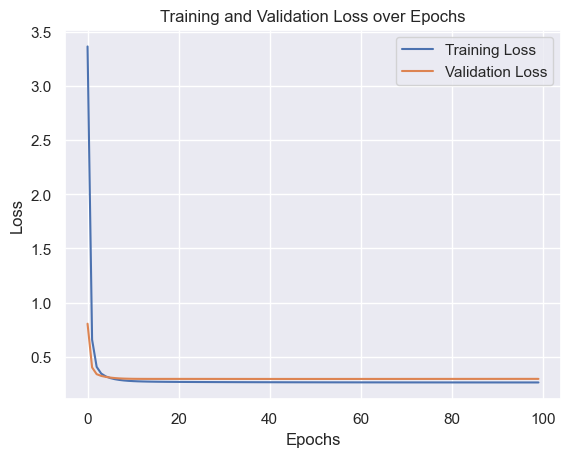

In [96]:
tf.random.set_seed(0)
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to build a linear regression model for tuning
def build_model_tuner(num_features, learning_rate):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
        units=1,
        input_shape=(num_features,),
        use_bias=True,
        kernel_initializer=tf.keras.initializers.Ones(),
        bias_initializer=tf.keras.initializers.Ones()
    ))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Fine-tune the learning rate and number of epochs
num_features = X_train_std.shape[1]

# Try different learning rates and number of epochs
learning_rate = 0.1
num_epochs = 100

# Build and compile the model
model_tf = build_model_tuner(num_features, learning_rate)

# Train the model and monitor the performance on the validation set
history = model_tf.fit(X_train_std, Y_train_std, epochs=num_epochs, validation_data=(X_val_std, Y_val_std))

print(model_tf)

# Step 2: Print the learned parameters (weights and bias)
weights, bias = model_tf.layers[0].get_weights()
print(f"Learned weights: {weights}")
print(f"Learned bias: {bias}")

# Step 3: Print the final epoch loss on training and validation datasets
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Final epoch training loss: {final_train_loss}")
print(f"Final epoch validation loss: {final_val_loss}")

# Step 4: Calculate the difference between the last-epoch training and validation loss
loss_difference = final_val_loss - final_train_loss
print(f"Difference between validation and training loss: {loss_difference}")

# Plot the loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Reloading Tuner from tuner_dir\linear_regression_tuning\tuner0.json
Best learning rate: 0.0005107172476545519
Epoch 1/1000


c:\Users\myk53\hello\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.6236 - val_loss: 5.1952
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5232 - val_loss: 5.1273
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4246 - val_loss: 5.0607
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3280 - val_loss: 4.9953
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2332 - val_loss: 4.9311
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1401 - val_loss: 4.8680
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0488 - val_loss: 4.8061
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9592 - val_loss: 4.7453
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8713 - val_loss: 4.6855
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7850 - val_loss: 4.6269
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7004 - val_loss: 4.5693
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6173 - val_los

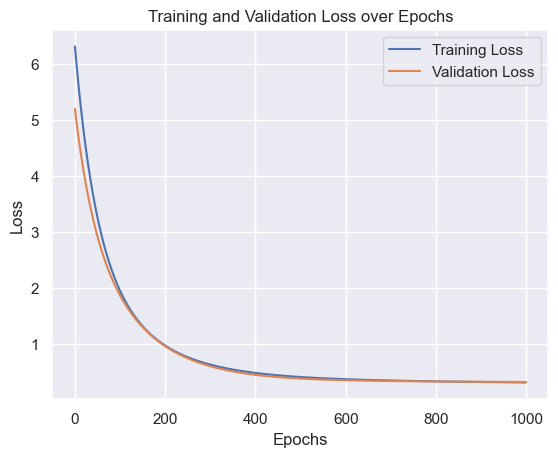

In [95]:
# Function to build a model for Keras Tuner
def build_model_tuner_kt(hp):
    learning_rate = hp.Float('learning_rate', min_value=0.00001, max_value=0.001, sampling='LOG')
    #LOG = Logarithmic sampling is ideal for exploring a wide range of learning rates efficiently, especially when small values make large differences in performance.
    num_features = X_train_std.shape[1]

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
        units=1,
        input_shape=(num_features,),
        use_bias=True,
        kernel_initializer=tf.keras.initializers.Ones(),
        bias_initializer=tf.keras.initializers.Ones()
    ))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Define the tuner
tuner = kt.RandomSearch(
    build_model_tuner_kt,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='linear_regression_tuning'
)

# Perform the hyperparameter search
tuner.search(X_train_std, Y_train_std, epochs=100, validation_data=(X_val_std, Y_val_std))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Train the best model
model_tf = tuner.hypermodel.build(best_hps)
history = model_tf.fit(X_train_std, Y_train_std, epochs=1000, validation_data=(X_val_std, Y_val_std))

# Step 2: Print the learned parameters (weights and bias)
weights, bias = model_tf.layers[0].get_weights()
print(f"Learned weights: {weights}")
print(f"Learned bias: {bias}")

# Step 3: Print the final epoch loss on training and validation datasets
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Final epoch training loss: {final_train_loss}")
print(f"Final epoch validation loss: {final_val_loss}")

# Step 4: Calculate the difference between the last-epoch training and validation loss
loss_difference = final_val_loss - final_train_loss
print(f"Difference between validation and training loss: {loss_difference}")

# Plot the loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized (tuned) model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 12:</span> Computing MSE (10 points)

1. Calculate the MSE on both (X_train_std, Y_train_std) and (X_test_std, Y_test_std) datasets. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your observations.

4. Generate a plot to visualize the accuracy of the predictions. Plot the actual (observed) Y_test values on the x-axis and the predicted Y_test values on the y-axis. Additionally, include a 45-degree line in the plot for reference. Ensure that the plot contains appropriate axis labels and a title. Provide commentary on the model's fit based on this visualization. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras. 

Training MSE: 0.2723010182380676
Test MSE: 0.24061910808086395
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
price    8449.729862
dtype: float64


C:\Users\myk53\AppData\Local\Temp\ipykernel_20288\3099661778.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_test_pred_original = Y_test_pred * std_Y_train[0] + mean_Y_train[0]  # Apply scalar scaling


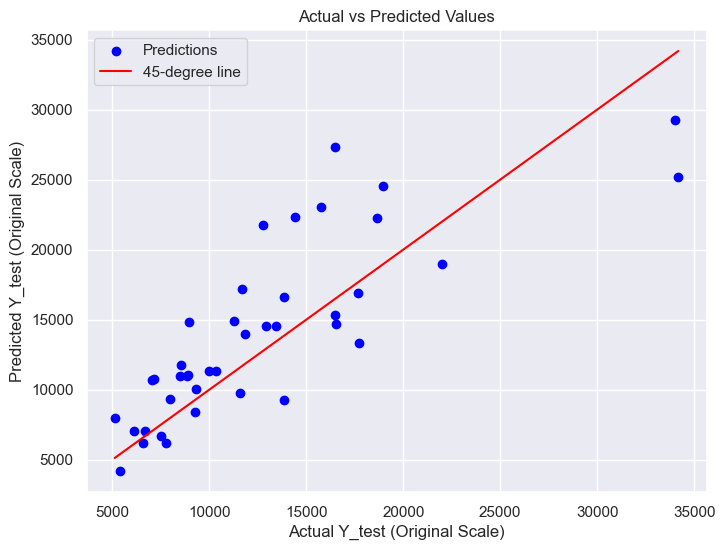

In [66]:
# YOUR CODE HERE
# Step 1: Evaluate the model on the training and test datasets
train_mse = model_tf.evaluate(X_train_std, Y_train_std, verbose=0)
test_mse = model_tf.evaluate(X_test_std, Y_test_std, verbose=0)

# Print the MSE results
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

# Step 2: Analyze generalization capabilities
# If test MSE is significantly higher than train MSE, the model may not generalize well

# Step 3: Generate predictions for the test set
Y_test_pred = model_tf.predict(X_test_std).flatten()

# Revert the predictions and actual Y_test values to the original scale
Y_test_original = Y_test_std * std_Y_train + mean_Y_train
Y_test_pred_original = Y_test_pred * std_Y_train[0] + mean_Y_train[0]  # Apply scalar scaling

# Step 4: Plot the actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_original, Y_test_pred_original, color='blue', label='Predictions')
plt.plot([Y_test_original.min(), Y_test_original.max()], [Y_test_original.min(), Y_test_original.max()], color='red', label='45-degree line')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Y_test (Original Scale)')
plt.ylabel('Predicted Y_test (Original Scale)')
plt.legend()
plt.show()


Answer:
1. I see that MSEs are close to each other, indicating that the model generalizes well:
Training MSE: 0.2723010182380676
Test MSE: 0.24061910808086395

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

In Exercise 12, you reported an aggregated MSE. Let's revisit the exercise by:

1. Performing a subgroup evaluation of the model. Specifically, calculate the test data MSE for the following makes: ['alfa-romero', 'audi', 'chevrolet', 'dodge', 'honda'].
2. Addressing the question: Is the model "fair" across each make?

In [79]:
# YOUR CODE HERE